# NLP Authorship Identification - Your Social Media Posts vs Bad CEOs'

![Image: image from https://trekkingwithdennis.com/tag/star-trek-voyager/](banner.png "image from trekkingwithdennis.com")

In this article, we will entertian ourselves by comparing our's, and, our galatic leaders' posts on the professional network BeamedIn, againts those of past earthling CEOs who were convicted frauds or unnanimously declared as unpleasant folk. 

We will do this with a technique called **Authorship Identification** in NLP.

This enables us to identify the most likely author of articles, news or messages. Authorship identification. This will be our aegies in navigating the multitude of Star Trek level of villinous propaganda in this age of social media

# Building an Unsupervised Learning Pipeline

Here are the steps we will undertake:
1. Clean these articles: stop words, lematize, and normalize.
2. Identify features, e.g. unique Bag of Words (BoW) or Latent Sematice Analysis (LSA)
3. 

Sentence-level Gated recurrent units (GRUs), predict authors on a small number (typically 3) of continuous sentences, which we call a sentence bundle cropped from an article.


The idea beneath this model is to capture an article’s style at sentence level. Although it seems
impractical to infer an author’s style from several sentences, this m

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
https://www.kaggle.com/code/miguelniblock/predict-the-author-unsupervised-nlp-lsa-and-bow
https://scikit-learn.org/dev/auto_examples/text/plot_document_clustering.html


In [206]:
# Pip below for Kaggle and online notebooks (should be done in production).
from sklearn.metrics import accuracy_score
!pip install ipywidgets
!pip install sklearn
!pip install spacy

# General-purpose Libraries
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import spacy
from time import time
%matplotlib inline

# Tools for processing data
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, make_scorer, adjusted_rand_score, silhouette_score, homogeneity_score, normalized_mutual_info_score
# Classifiers, supervised and unsupervised
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('./communications.csv')
data.head(3)


,publication,author,content
0,podcast,Elizabeth Holmes,"First, they think you're crazy, then they figh..."
1,messages,Elizabeth Holmes,‘You are the breeze in desert for me.’ ‘My wat...
2,messages,Elizabeth Holmes,The right to protect the health and well-being...


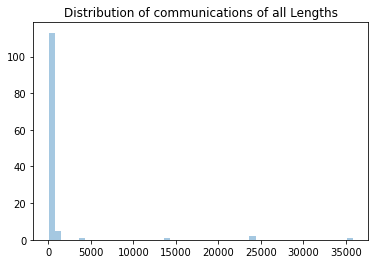

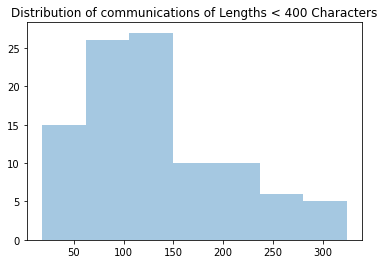

Elizabeth Holmes    48
Trevor Milton       21
Adam Neumann        20
Jeffrey Skilling    15
Donald Trump        13
Sunny Balwani        3
Name: author, dtype: int64

Number of articles: 123
Unique articles: 123


In [207]:
lengths = pd.Series([len(x) for x in data.content])
authors_data = data.copy()

lengths = pd.Series([len(x) for x in authors_data.content])

sns.distplot(lengths, kde=False)
plt.title('Distribution of communications of all Lengths')
plt.show()
sns.distplot(lengths[lengths < 400], kde=False)
plt.title('Distribution of communications of Lengths < 400 Characters')
plt.show()

print(authors_data.author.value_counts()[authors_data.author.value_counts() < 100][-10:])

print('\nNumber of articles:', authors_data.shape[0])
print('Unique articles:', len(np.unique(authors_data.index)))

In [208]:
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

common_words = []
corpus = ""
author_content = authors_data['content'].iloc
for article in author_content:
    corpus = corpus + article

doc = nlp(corpus)

lemmas = [token.lemma_ for token in doc
            if not token.is_punct and not token.is_stop]
bow = [item[0] for item in Counter(lemmas).most_common(1000)]
for word in bow:
    common_words.append(word)

common_words = [word.lower() for word in common_words]
common_words = set(common_words)


print('Total number of common words:', len(common_words))


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Total number of common words: 981


0 corpus contains 16  words.
1 corpus contains 16  words.
2 corpus contains 16  words.
3 corpus contains 16  words.
4 corpus contains 16  words.
5 corpus contains 16  words.
6 corpus contains 16  words.
7 corpus contains 16  words.
8 corpus contains 16  words.
9 corpus contains 16  words.
10 corpus contains 16  words.
11 corpus contains 16  words.
12 corpus contains 16  words.
13 corpus contains 16  words.
14 corpus contains 16  words.
15 corpus contains 16  words.
16 corpus contains 16  words.
17 corpus contains 16  words.
18 corpus contains 16  words.
19 corpus contains 16  words.
20 corpus contains 16  words.
21 corpus contains 16  words.
22 corpus contains 16  words.
23 corpus contains 16  words.
24 corpus contains 16  words.
25 corpus contains 16  words.
26 corpus contains 16  words.
27 corpus contains 16  words.
28 corpus contains 16  words.
29 corpus contains 16  words.
30 corpus contains 16  words.
31 corpus contains 16  words.
32 corpus contains 16  words.
33 corpus contains 1

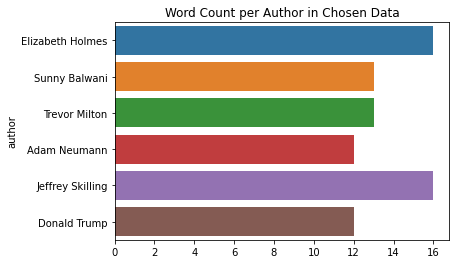

In [209]:
authors_data.dropna(inplace=True)

lengths = []
for k, v in authors_data.author.items():
    print(k, 'corpus contains', len(v), ' words.')
    lengths.append(len(v))
sns.barplot(x=lengths, y=authors_data.author, orient='h')
plt.title('Word Count per Author in Chosen Data')
plt.show()


In [210]:
# We must remove these in to avoid conflicts with existing features.
if 'author' in common_words:
    common_words.remove('author')
if 'publication' in common_words:
    common_words.remove('publication')
if 'content' in common_words:
    common_words.remove('content')

bow_counts = pd.DataFrame()
for name in np.unique(authors_data.author):
    # Select X articles of that author
    articles = authors_data.loc[authors_data.author == name, :][:50]
    bow_counts = bow_counts.append(articles)
bow_counts = bow_counts.reset_index().drop('index', 1)

df = pd.DataFrame(columns=common_words)
bow_counts = bow_counts.join(df)
bow_counts.loc[:,common_words] = 0
for i, article in enumerate(bow_counts.content):
    doc = nlp(article)
    for token in doc:
        if token.lemma_.lower() in common_words:
            bow_counts.loc[i,token.lemma_.lower()] += 1
            
bow_counts.dropna(inplace=True)
print(bow_counts.shape)
bow_counts.head(3)


(120, 984)


,publication,author,content,course,want,sarah,missile,sit,function,motor,...,match,oh,put,different,reduction,separation,partnership,touch,east,go
0,messages,Adam Neumann,Success is not just making money. Success is h...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,messages,Adam Neumann,How do you change the world? Bring people toge...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,messages,Adam Neumann,"Before WeWork, I had a baby clothing company. ...",0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [211]:
y = bow_counts['author']
X = bow_counts.drop(['content','author','publication'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.24,
                                                    random_state=0,
                                                    stratify=y)
                                                    
params = [{
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l2']
    },{
    'solver': ['liblinear','saga'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l1','l2']
}]
clf = LogisticRegression(
    n_jobs=-1 # Use all CPU
)

search = GridSearchCV(clf, params, cv=3).fit(X, y)
best = search.best_estimator_
cv = cross_val_score(X=X, y=y, estimator=best, cv=5)
best = best.fit(X_train, y_train)

In [212]:
y_pred = best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Processed with accuracy_score {accuracy}\n')

y_pred = best.predict(pd.DataFrame(X.iloc[[13]]))
data = bow_counts.loc[[13], ['author', 'publication', 'content']]
print(f'Predicting\n{data}\nas\n{y_pred}\n')

Processed with accuracy_score 0.5517241379310345

Predicting
          author publication  \
13  Adam Neumann    messages   

                                              content  
13  When we launched WeWork back in 2010, we saw o...  
as
['Elizabeth Holmes']



In [213]:
vectorizer = TfidfVectorizer(max_df=0.3,  
                             min_df=8,  
                             stop_words='english',
                             lowercase=True,  
                             use_idf=True, 
                             norm=u'l2', 
                             smooth_idf=True 
                             )

counts_tfidf = vectorizer.fit_transform(bow_counts.content)
svd = TruncatedSVD(17)
svd.fit(counts_tfidf)

lsa = make_pipeline(svd, Normalizer(copy=False))
lsa_data = lsa.fit_transform(counts_tfidf)
lsa_data = pd.DataFrame(lsa_data)

y_lsa = bow_counts['author']
X_lsa = lsa_data

params = [{
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l2']
}, {
    'solver': ['liblinear', 'saga'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l1', 'l2']
}]

clf = LogisticRegression(
    n_jobs=-1  # Use all CPU
)

search = GridSearchCV(clf, params, cv=3).fit(X, y)
best = search.best_estimator_
cv = cross_val_score(X=X_lsa, y=y_lsa, estimator=best, cv=5)

X_train, X_test, y_train, y_test = train_test_split(X_lsa, y_lsa,
                                                    test_size=0.24,
                                                    random_state=0,
                                                    stratify=y)

best = best.fit(X_train, y_train)


In [214]:
y_pred = best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Processed with accuracy_score {accuracy}\n')

y_pred = best.predict(pd.DataFrame(X_lsa.iloc[[13]]))
data = bow_counts.loc[[13], ['author', 'publication', 'content']]
print(f'Predicting\n{data}\nas\n{y_pred}\n')


Processed with accuracy_score 0.3793103448275862

Predicting
          author publication  \
13  Adam Neumann    messages   

                                              content  
13  When we launched WeWork back in 2010, we saw o...  
as
['Elizabeth Holmes']



# Concluding our Analysis



# References

- https://spacy.io

## Github and Kaggle

Article here is also available on [Github]() and [Kaggle]()

#
<div align="right">Made with :heartpulse: by <b>Adam</b></div>